# STEP 0: PROJECT SETUP

### Import libraries:

In [1]:
import os
import random
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing import image as im
%matplotlib inline

Using TensorFlow backend.


### Set up local project directory

In [2]:
os.chdir('E:/DeepLearning/dog_breeds')
print(os.getcwd())

E:\DeepLearning\dog_breeds


# STEP 1: PREPARE LABELS

### Read labels file and display the first and last 5 rows:

In [3]:
labels = pd.read_csv('labels.csv')
display(labels.iloc[np.r_[0:5, -5:0]])

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
10217,ffd25009d635cfd16e793503ac5edef0,borzoi
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher
10221,fff43b07992508bc822f33d8ffd902ae,chesapeake_bay_retriever


### Select Train, Validate and Test sets at random from labels dataframe (70:15:15):

In [4]:
# set seed for reproducibility
random.seed(123)

# get list of all image id's in labels data
id_list = [id for id in labels.id]

# percentage assigned to train set (70% of total)
id_list_train = random.sample(id_list, int(np.round(len(id_list) * 0.70)))  

# remove images assigned to train set
id_list = [id for id in id_list if id not in id_list_train]  

# assign half of non-train images to validate set (15% of total)
id_list_validate = random.sample(id_list, int(np.round(len(id_list) * 0.50)))  

# remaining images are test set
id_list_test = [id for id in id_list if id not in id_list_validate]  

print(f"Total:{len(id_list)} / Train:{len(id_list_train)} / Validate:{len(id_list_validate)} / Test:{len(id_list_test)}")

Total:3067 / Train:7155 / Validate:1534 / Test:1533


# STEP 2: PREPARE IMAGES

### Resize images and copy them to Train, Validate and Test folders, and into each corresponding classification folder (Optional data augmentation):

In [5]:
# to bypass the data augmentation process set "augment_size = 0" 
def process_images(list_src, path_src, path_dst, subfolders, augment_size, img_size):    
    
    augment = im.ImageDataGenerator(rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2,
                                rescale=1/255, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

    for id in list_src:    
        
        if subfolders is True:            
            # make subfolders using breed labels
            breed = labels[labels.id == id].breed.item()  
            if not os.path.exists(f"{path_dst}{breed}"):
                os.makedirs(f"{path_dst}{breed}")
        else:
            # no subfolders used
            breed = '' 
        
        # read and resize images
        img = cv.imread(f"{path_src}{id}.jpg")    
        img = cv.resize(img, img_size)

        # save original images
        cv.imwrite(f"{path_dst}{breed}/{id}.jpg", img)    

        # save augmented images (optional)
        if augment_size > 0:            
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            x = img.reshape((1,) + img.shape)
            i = 0
            for batch in augment.flow(x, save_to_dir=f"{path_dst}{breed}", save_prefix=f"{id}", save_format='jpg'):
                i += 1
                if i >= augment_size:
                    break         
        
            
print('Image preparation in progress...')

process_images(id_list_train[0:50], 'downloaded/train/', 'train/', subfolders=True, augment_size=4, img_size=(64,64))
process_images(id_list_validate[0:50], 'downloaded/train/', 'validate/', subfolders=True, augment_size=4, img_size=(64,64))
process_images(id_list_test[0:50], 'downloaded/train/', 'test/', subfolders=False, augment_size=0, img_size=(64,64))

print('Image preparation completed successfully')

Image preparation in progress...
Image preparation completed successfully


### Display a few sample images from Train and Validate folders:

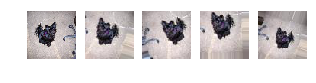

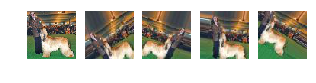

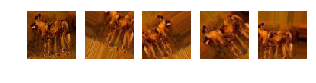

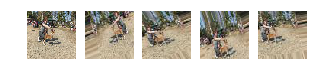

In [6]:
def sample_images(path, num_folders):

    dir_list = os.listdir(path)[0:num_folders]

    for dir in dir_list:     
        prefix = os.listdir(f'{path}/{dir}')[0].replace('.jpg', '')    
        img_files = [filename for filename in os.listdir(f'{path}/{dir}') if filename.startswith(prefix)]
        tot_img_files = len(img_files)

        fig = plt.figure(figsize=(tot_img_files, tot_img_files))            
        for k in range(0, tot_img_files):    
            fig.add_subplot(1, tot_img_files, k+1)
            plt.imshow(im.load_img(f'{path}/{dir}/{img_files[k]}'))
            plt.axis('off')        
            
sample_images('train', 2)
sample_images('validate', 2)

# STEP 3: PREPARE DEEP LEARNING MODEL

### Load images to model